<a href="https://colab.research.google.com/github/Akanksha-cell-max/Advanced-Artificial-Intelligence/blob/main/Practical_No_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install lime torch torchvision matplotlib scikit-image opencv-python


True Label: 3, Predicted: 3


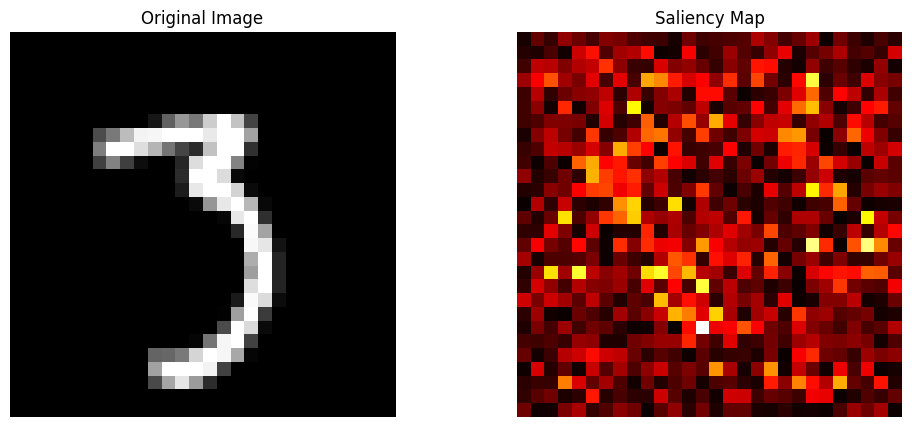

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import cv2

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 28x28 -> 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 14x14 -> 7x7
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# 3. Train the model (just one batch for demo purposes)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# quick training on one batch
model.train()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

# 4. Pick one test image
model.eval()
test_images, test_labels = next(iter(testloader))
test_image = test_images[0].to(device)
test_label = test_labels[0]

# Predict
output = model(test_image.unsqueeze(0))
predicted_class = torch.argmax(output, 1).item()

print(f"True Label: {test_label.item()}, Predicted: {predicted_class}")

# ===================== SALIENCY MAP ==========================

# Enable gradients
test_image.requires_grad_()
output = model(test_image.unsqueeze(0))
score = output[0, predicted_class]
score.backward()

# Saliency computation
saliency = test_image.grad.data.abs().squeeze().cpu().numpy()
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize

# Correctly handle the image format for display
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image.squeeze().cpu().detach().numpy(), cmap='gray')  # .numpy() is needed for plotting
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()


# ===================== LIME EXPLANATION ==========================

# LIME expects numpy images
def predict_fn(images_np):
    images_tensor = torch.tensor(images_np).permute(0, 3, 1, 2).float() / 255.0
    images_tensor = images_tensor[:, 0:1, :, :]  # Keep 1 channel
    outputs = model(images_tensor.to(device)).detach().cpu().numpy()
    return outputs

pil_image = transforms.ToPILImage()(test_image.squeeze().cpu())

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_image),
                                         predict_fn,
                                         top_labels=1,
                                         hide_color=0,
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(label=predicted_class, positive_only=True, hide_rest=False)

plt.figure(figsize=(8, 5))
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

# ===================== GRAD-CAM ==========================

# Hook the gradients
gradients = []
activations = []

def save_gradient(module, input, output):
    gradients.append(output)

def save_activation(module, input, output):
    activations.append(output)

# Attach hooks to second convolution layer
target_layer = model.conv2
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

# Forward pass
model.zero_grad()
output = model(test_image.unsqueeze(0))
predicted_score = output[0, predicted_class]
predicted_score.backward()

# Get hooked gradients and activations
grad = gradients[0].squeeze().cpu().detach()
act = activations[0].squeeze().cpu().detach()

# Compute weights
weights = grad.mean(dim=(1, 2))  # Global Average Pooling
grad_cam = torch.zeros(act.shape[1:], dtype=torch.float32)

for i, w in enumerate(weights):
    grad_cam += w * act[i, :, :]

# ReLU
grad_cam = torch.clamp(grad_cam, min=0)
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize

# Resize Grad-CAM to match image size
grad_cam_resized = cv2.resize(grad_cam.numpy(), (28, 28))

plt.figure(figsize=(8, 5))
plt.title("Grad-CAM")
plt.imshow(test_image.squeeze().cpu(), cmap='gray')
plt.imshow(grad_cam_resized, cmap='jet', alpha=0.5)  # overlay
plt.axis('off')
plt.show()
